In [1]:
import funs
import funs.model as model

import torch
import os

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import transforms

import pandas as pd 

In [2]:
config = funs.load_yaml('./config.yaml')

funs.set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


In [3]:
model_name = 'FRFconv-TDS'
log_file = 'log_per_acc_test.txt'
cm_name = 'confusion_matrix_test.png' \
''

In [4]:
data_root_dirs = os.path.join(config.dataset_root)

Cylindrical_dirs = funs.get_bearing_paths(data_root_dirs, 'CylindricalRoller', config.rpm, config.sampling_rate)
DepGroove_dirs = funs.get_bearing_paths(data_root_dirs, 'DeepGrooveBall', config.rpm, config.sampling_rate)
Tapered_dirs = funs.get_bearing_paths(data_root_dirs, 'TaperedRoller', config.rpm, config.sampling_rate )

In [5]:
print("Making dataframes...")

Cylindrical_df = funs.make_dataframe(config, Cylindrical_dirs)
DepGroove_df =funs.make_dataframe(config, DepGroove_dirs)
Tapered_df = funs.make_dataframe(config, Tapered_dirs)

Making dataframes...


In [6]:
print("concat dataframes...")

all_df = pd.concat([Cylindrical_df, DepGroove_df, Tapered_df], ignore_index=True)

concat dataframes...


In [7]:
train_df, val_df, test_df = funs.split_dataframe(all_df, 0.6, 0.2)

train_data, train_label = funs.build_from_dataframe(train_df, config.sample_size, config.overlap, False)
val_data, val_label = funs.build_from_dataframe(val_df, config.sample_size, config.overlap, False)
test_data, test_label = funs.build_from_dataframe(test_df, config.sample_size, config.overlap, False)

In [8]:
# np -> tensor transform
tf_data = transforms.Compose([funs.processing.NpToTensor(), funs.processing.ToSignal()])
tf_label = transforms.Compose([funs.processing.NpToTensor()])

In [9]:
train_dataset = funs.NumpyDataset(train_data, train_label, transform=tf_data, target_transform=tf_label)
val_dataset = funs.NumpyDataset(val_data, val_label, transform=tf_data, target_transform=tf_label)
test_dataset = funs.NumpyDataset(test_data, test_label, transform=tf_data, target_transform=tf_label)

train_loader = funs.get_dataloader(train_dataset, config.batch_size, True)
val_loader = funs.get_dataloader(val_dataset, config.batch_size, False)
test_loader = funs.get_dataloader(test_dataset, config.batch_size, False)

In [10]:
for batch in test_loader:
    # batch가 tuple이면 (inputs, labels) 형태일 수 있음
    if isinstance(batch, (tuple, list)):
        inputs = batch[0]
    else:
        inputs = batch

    print("모델 입력 shape:", inputs.shape)
    break  # 첫 배치만 확인

모델 입력 shape: torch.Size([128, 1, 2048])


In [11]:
n_classes = all_df["label"].max() - all_df["label"].min() + 1
model = model.Mynet2(n_classes=n_classes).to(device)

In [12]:
optimizer = Adam(model.parameters(), lr = float(config.learning_rate))
loss = CrossEntropyLoss()

In [14]:
trainer = funs.Trainer(model, loss, optimizer, device, train_loader, val_loader)
# train_loss, val_loss = trainer.train(config.epoch)
# trainer.save(config.model_root, model_name)

model_path = f'{config.model_root}/{model_name}.pt'
trainer.model.load_state_dict(torch.load(model_path, weights_only=True))

fault_label_list, val_loss, predicted_label_list = trainer.test(test_loader) 


Starting Test... 
----------------------------------------
tensor([[ -0.8566,  -5.3277,  -4.8363,  ...,  10.8760,   0.4290,  -1.1316],
        [ -0.8664,  -3.5442,  -6.3703,  ...,  10.3327,   2.7321,  -1.5687],
        [ -0.1956,  -4.2155,  -5.6977,  ...,  10.2797,   1.4573,  -1.5286],
        ...,
        [-49.6249,  -4.9172,   2.2511,  ..., -54.1498, -18.2134, -19.5100],
        [-24.3564,  -1.9420,   3.9467,  ..., -25.2131,  -9.8738, -10.2815],
        [-22.7964,  -1.8707,  -0.6696,  ..., -25.2142,  -7.1775, -11.1160]],
       device='cuda:0')
tensor([[-42.2489,  -5.6783,   2.9855,  ..., -46.1754, -18.1027, -16.3618],
        [-35.4805,  -2.0281,  -1.7696,  ..., -40.6865, -11.6273, -16.1657],
        [-27.7263,  -2.9191,   0.3911,  ..., -33.6251,  -9.4362, -14.3751],
        ...,
        [ -9.7799,   5.4415,   3.1610,  ...,  -1.0122,  -3.7523, -10.9928],
        [ -8.9011,   8.8285,  -1.9143,  ...,  -8.7785,  -2.5442, -12.3482],
        [-13.7886,   9.7199,   1.1601,  ..., -14.1060

Class-wise Accuracy:
Class 0: 0.93952
Class 1: 0.98432
Class 2: 0.99462
Class 3: 0.45923
Class 4: 0.77016
Class-wise accuracy logged to log_per_acc_test.txt


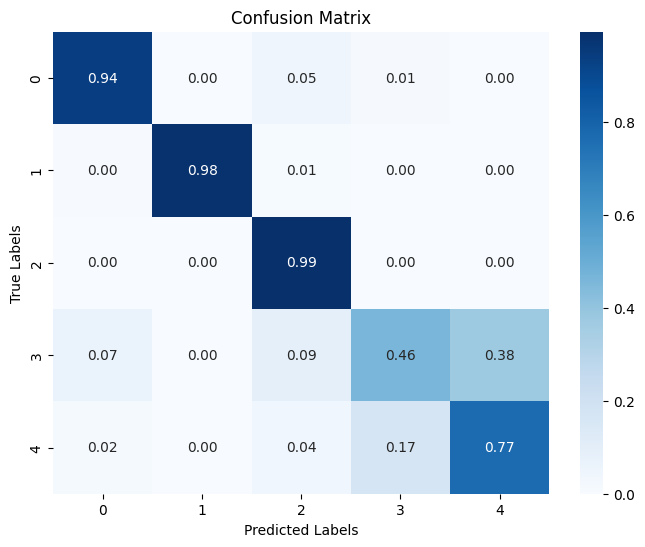

In [ ]:
# acc per class logging
funs.log_class_acc(config.log_root, fault_label_list, predicted_label_list, f'{log_file}')

# confusion matrix plot
funs.plot_confusion_matrix(config.pic_root ,fault_label_list, predicted_label_list, cm_name)